In [1]:
#!pip install --upgrade pip
#!pip install GEOS
#!pip install GeobricksProj4ToEPSG
#!conda install -c conda-forge cartopy --yes
#!pip install geopandas
print('ok')
#!pip install --upgrade setuptools

ok


In [2]:
import os
import pandas
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML
import geopandas as gpd
#from shapely.geometry import Polygon
#from shapely.ops import cascaded_union, unary_union#, union
import time
import io
#import rtree

os.chdir('/home/idies/workspace/Temporary/raddick/cra_scratch/')
print(os.getcwd())
outdir = '/home/idies/workspace/Storage/raddick/persistent/cra/'
print(outdir)

/home/idies/workspace/Temporary/raddick/cra_scratch
/home/idies/workspace/Storage/raddick/persistent/cra/


# Lending by geography of borrowers

In [3]:
baltimore_tracts_df = pandas.read_csv('tracts_processed.csv', encoding='utf-8', index_col='rownumber')
print('{0:,.0f} tract datas nationwide.'.format(len(baltimore_tracts_df)))

baltimore_tracts_df = baltimore_tracts_df[(baltimore_tracts_df['state'] == 24) & (baltimore_tracts_df['county'] == 510)]
print('{0:,.0f} tract datas in Baltimore.'.format(len(baltimore_tracts_df)))

print('Fixing MSA weirdness...')
baltimore_tracts_df = baltimore_tracts_df.drop('msa_name', axis=1)
baltimore_tracts_df = baltimore_tracts_df.rename(columns={'cbsa_name': 'msa_name'})

print('Converting full level system to low/moderate/medium/upper...')
baltimore_tracts_df = baltimore_tracts_df.assign(cra_level = '')
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 1) & (x <=5))), 'cra_level'] = 'low'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 6) & (x <=8))), 'cra_level'] = 'moderate'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 9) & (x <=12))), 'cra_level'] = 'middle'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x == 13))), 'cra_level'] = 'upper'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 14) & (x <=15))), 'cra_level'] = 'unknown'

print('backing up...')
baltimore_tracts_df_bk = baltimore_tracts_df
print('ok')

#baltimore_tracts_df
print('\nDONE!')


/home/idies/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


22,761,175 tract datas nationwide.
61,098 tract datas in Baltimore.
Fixing MSA weirdness...
Converting full level system to low/moderate/medium/upper...
backing up...
ok

DONE!


In [4]:
print('reading from backup...')
baltimore_tracts_df = baltimore_tracts_df_bk

print('adding CSA data...')
census_tract_to_neighborhood_df = pandas.read_csv('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/census_tract_to_neighborhood.csv', low_memory=False)#, index_col='NAME10')
census_tract_to_neighborhood_df = census_tract_to_neighborhood_df.set_index('NAME10')

baltimore_tracts_df = baltimore_tracts_df.join(census_tract_to_neighborhood_df, how='left', on='census_tract')

print('backing up...')
baltimore_tracts_df_bk = baltimore_tracts_df
print('\nok')

#census_tract_to_neighborhood_df#.dtypes

reading from backup...
adding CSA data...
backing up...

ok


# Analysis by census tract

## Process data using a multi-index

In [5]:
print('retrieving from backup...')
baltimore_tracts_df = baltimore_tracts_df_bk

print('grouping...')

tractdata = baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y'].groupby(['census_tract', 'cra_level', 'activity_year', 'institution_name']).size()

tractdata = tractdata.sort_index()
# Run this to get every index value to display in every row:
#pandas.set_option('display.multi_sparse', False)

# GET ALL ROWS THAT MATCH A GIVEN CRITERION FROM A GIVEN LEVEL
#tractdata.xs(101.00, level=0) #Access all loans given in census tract 101
#tractdata.xs('low', level=1) # Access all loans given to low income group 
#tractdata.xs(2016, level=2) # Access all loans given in 2016
#tractdata.xs('WELLS FARGO BANK, N.A. (CA)', level=3) # Access all loans given by Wells Fargo

# FIND NUMBER OF LOANS FOR EACH VALUE AT EACH LEVEL

#tractdata.groupby([pandas.Grouper(level='census_tract')]).sum() # Number of loans given in each census tract
#tractdata.groupby([pandas.Grouper(level='cra_level')]).sum() # Number of loans given at each CRA income level
#tractdata.groupby([pandas.Grouper(level='activity_year')]).sum() # Number of loans given per year
#tractdata.groupby([pandas.Grouper(level='institution_name')]).sum() # Number of loans given per institution


# ITERATE THROUGH VALUES OF AN INDEX LEVEL AND SEE THE GROUPS FORMED BY THOSE VALUES
#grouped_by_census_tract = tractdata.groupby('census_tract')
#for name, group in grouped_by_census_tract:
#    print(name)
#    print(group)
#    print('\n')

# ACCESS A GROUP ASSOCIATED WITH A SPECIFIC VALUE ONE ONE LEVEL...
#grouped_by_census_tract = tractdata.groupby('census_tract')
#grouped_by_census_tract.get_group(101.00)
# OR ON MULTIPLE LEVELS...
#tractdata.groupby(['census_tract', 'institution_name']).get_group((101, '1ST MARINER BANK (MD)')) # note get_group takes a tuple

print('backing up...')
tractdata_bk = tractdata

print('OK')
#tractdata

retrieving from backup...
grouping...
backing up...
OK


## Get shapefile and connect with loan data

In [6]:
s = time.time()
print('reading shapefile...')

tract_shapes_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/census_tracts_2010/geo_export_c50bbe56-543e-4878-9c9f-c56be327600a.shp', encoding='utf-8')
tract_shapes_gdf = tract_shapes_gdf.assign(tractname = pandas.to_numeric(tract_shapes_gdf['name'].apply(lambda x: x.split(' ')[-1]), errors='coerce'))
tract_shapes_gdf = tract_shapes_gdf.set_index('tractname')
e = time.time()

print('Read {0:,.0f} Maryland census tracts in {1:.3f} seconds.'.format(len(tract_shapes_gdf), e-s))

print('\nCalculating percent white...')
tract_shapes_gdf = tract_shapes_gdf.assign(percent_white = tract_shapes_gdf['white'] / tract_shapes_gdf['population'])


print('getting tract loan data from backup...')
tractdata = tractdata_bk

#tractdata
print('Grouping by tract only...')
grouped_by_census_tract = tractdata.groupby('census_tract').sum()

print('\nAdding loan data to shape data...')
tract_shapes_gdf = tract_shapes_gdf.assign(nLoans=grouped_by_census_tract)

print('reading water features...')
water_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/water/water.shp', encoding='utf-8')
water_gdf = water_gdf.set_index('OBJECTID')
water_gdf.sort_values('Shape_Area', ascending=False)
#water_gdf.crs

print('matching up CRSes...')
tract_shapes_gdf = tract_shapes_gdf.to_crs(water_gdf.crs)

print('\nbacking up...')
tract_shapes_gdf_bk = tract_shapes_gdf

print('ok')

reading shapefile...
Read 200 Maryland census tracts in 0.081 seconds.

Calculating percent white...
getting tract loan data from backup...
Grouping by tract only...

Adding loan data to shape data...
reading water features...
matching up CRSes...

backing up...
ok


## Make maps by census tract

Saving...
DONE!


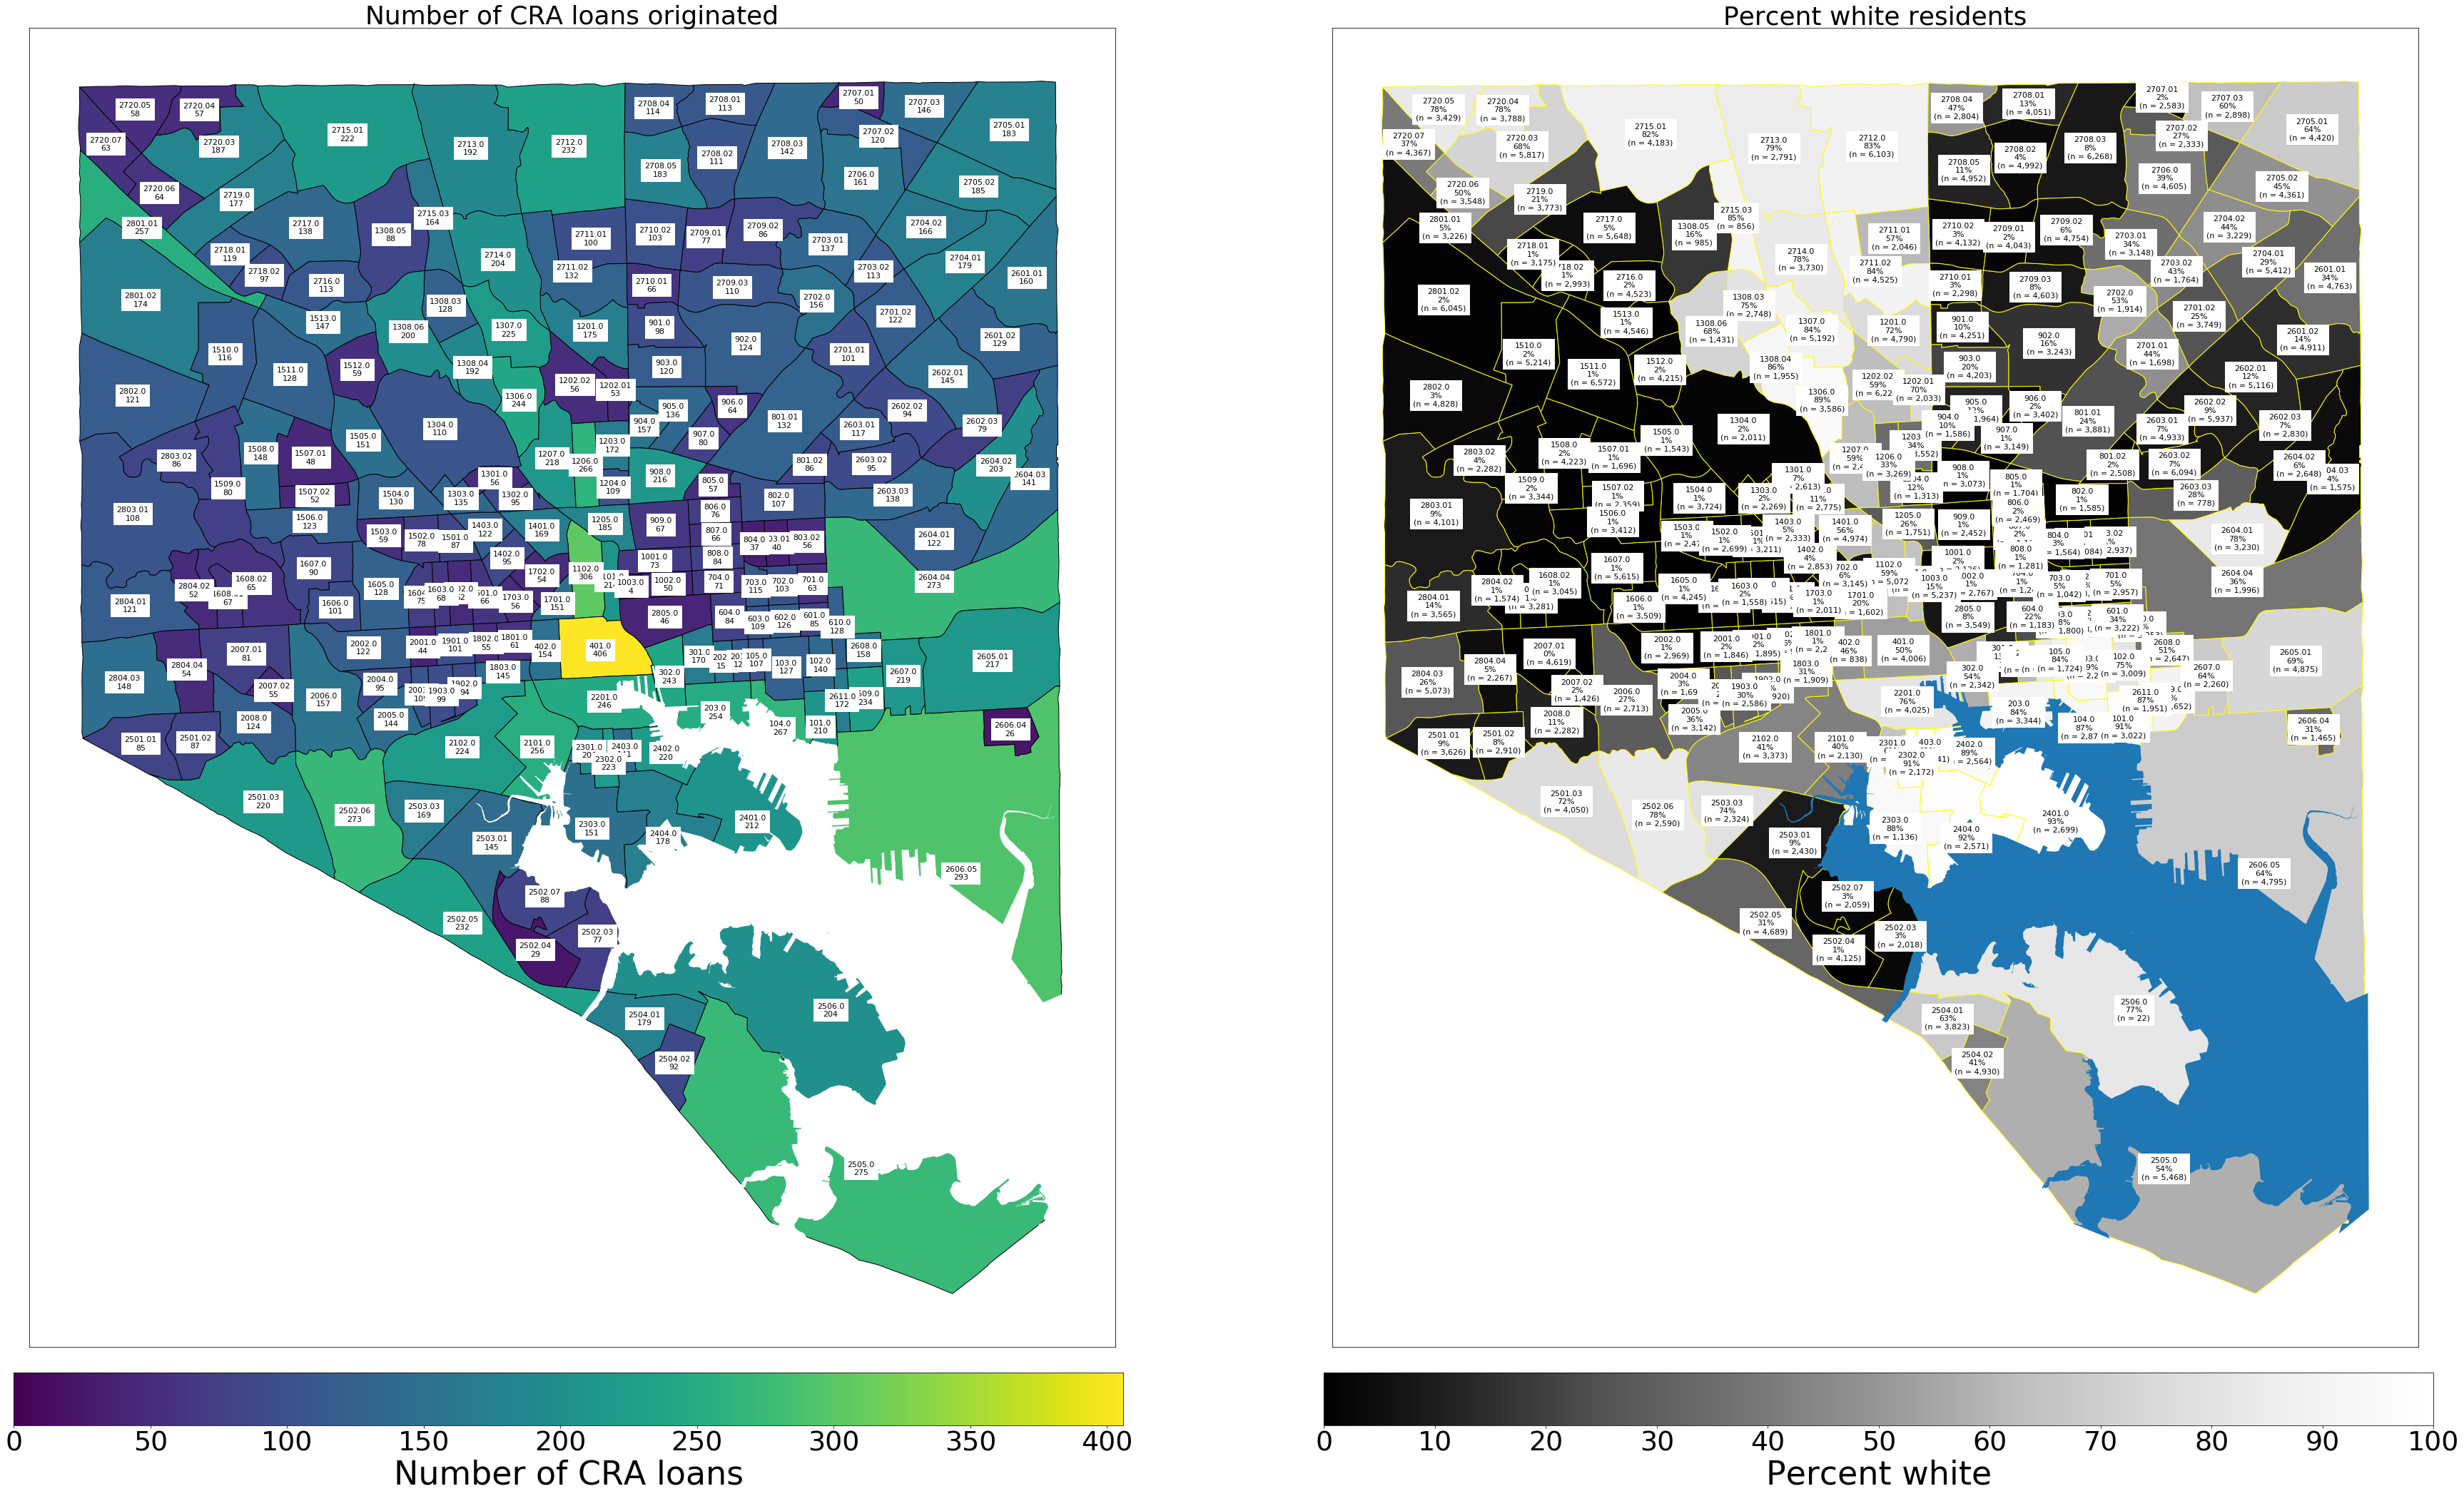

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60,34))

ax1 = tract_shapes_gdf.plot(ax=ax1, column='nLoans', cmap='viridis', edgecolor='black')
ax1.set_title('Number of CRA loans originated', fontsize=36)
ax1.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax1, color='w')

for ix, thisrow in tract_shapes_gdf[tract_shapes_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0f}'.format(thisrow['nLoans'])
#        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax1.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)

ax2 = tract_shapes_gdf.plot(ax=ax2, column='percent_white', cmap='Greys_r', edgecolor='yellow')
ax2.set_title('Percent white residents', fontsize=36)
ax2.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax2)

for ix, thisrow in tract_shapes_gdf[tract_shapes_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0%}'.format(thisrow['percent_white'])
        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax2.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)


ax1.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')
ax2.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])

sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=tract_shapes_gdf['nLoans'].max()))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, orientation='horizontal')

cax1.tick_params(labelsize=38)
cbar1.set_label('Number of CRA loans', fontsize=46)


# add colorbar

sm2 = plt.cm.ScalarMappable(cmap='Greys_r', norm=plt.Normalize(vmin=0, vmax=100))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', ticks=np.arange(0, 110, 10), orientation='horizontal')
cax2.tick_params(labelsize=38)
cbar2.set_label('Percent white', fontsize=46)


#plt.show()

print('Saving...')
fig.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_loans_by_census_tract.svg', format='svg', dpi=300)
print('DONE!')


# Analysis by CSA

## Process data using a multi-index

In [8]:
print('retrieving tracts data from backup...')
baltimore_tracts_df = baltimore_tracts_df_bk

print('grouping by community statistical area...')

csaloans_df = baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y'].groupby(['CSA2010', 'cra_level', 'activity_year', 'institution_name']).size()

csaloans_df = csaloans_df.sort_index()
# Run this to get every index value to display in every row:
#pandas.set_option('display.multi_sparse', False)

# GET ALL ROWS THAT MATCH A GIVEN CRITERION FROM A GIVEN LEVEL
#tractdata.xs(101.00, level=0) #Access all loans given in census tract 101
#tractdata.xs('low', level=1) # Access all loans given to low income group 
#tractdata.xs(2016, level=2) # Access all loans given in 2016
#tractdata.xs('WELLS FARGO BANK, N.A. (CA)', level=3) # Access all loans given by Wells Fargo

# FIND NUMBER OF LOANS FOR EACH VALUE AT EACH LEVEL

#tractdata.groupby([pandas.Grouper(level='census_tract')]).sum() # Number of loans given in each census tract
#tractdata.groupby([pandas.Grouper(level='cra_level')]).sum() # Number of loans given at each CRA income level
#tractdata.groupby([pandas.Grouper(level='activity_year')]).sum() # Number of loans given per year
#tractdata.groupby([pandas.Grouper(level='institution_name')]).sum() # Number of loans given per institution


# ITERATE THROUGH VALUES OF AN INDEX LEVEL AND SEE THE GROUPS FORMED BY THOSE VALUES
#grouped_by_census_tract = tractdata.groupby('census_tract')
#for name, group in grouped_by_census_tract:
#    print(name)
#    print(group)
#    print('\n')

# ACCESS A GROUP ASSOCIATED WITH A SPECIFIC VALUE ONE ONE LEVEL...
#grouped_by_census_tract = tractdata.groupby('census_tract')
#grouped_by_census_tract.get_group(101.00)
# OR ON MULTIPLE LEVELS...
#tractdata.groupby(['census_tract', 'institution_name']).get_group((101, '1ST MARINER BANK (MD)')) # note get_group takes a tuple

print('\nbacking up...')
csaloans_df_bk = csaloans_df

print('grouping number of loans by CSA...')
nloans_by_csa = csaloans_df.groupby('CSA2010').sum()
nloans_by_csa.name = 'nLoans'

print('OK')
csaloans_df.sample(2)

retrieving tracts data from backup...
grouping by community statistical area...

backing up...
grouping number of loans by CSA...
OK


CSA2010                        cra_level  activity_year  institution_name          
Greenmount East                low        2016           American Express, FSB (UT)    4
Allendale/Irvington/S. Hilton  low        2016           ALLY BANK (UT)                1
dtype: int64

## Get population data for neighborhoods from their census tracts

In [9]:
print('Adding CSA names to tract geodata...')
census_tract_to_neighborhood_df = pandas.read_csv('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/census_tract_to_neighborhood.csv', low_memory=False)
census_tract_to_neighborhood_df['NAME10'] = pandas.to_numeric(census_tract_to_neighborhood_df['NAME10'], errors='coerce')
census_tract_to_neighborhood_df = census_tract_to_neighborhood_df.set_index('NAME10')

tract_shapes_with_csa_gdf = tract_shapes_gdf.join(census_tract_to_neighborhood_df, how='left')

csa_gdf = tract_shapes_with_csa_gdf.groupby('CSA2010')[['white', 'population']].sum()

csa_gdf.sample(2)

Adding CSA names to tract geodata...


,white,population
CSA2010,,
Belair-Edison,1771.0,17416.0
Harford/Echodale,7029.0,16839.0


##  Get CSA shapefiles

In [10]:
print('We have tract-based population data for {0:,.0f} CSAs, and CSA-based loan data for {1:,.0f}'.format(len(csa_gdf), len(nloans_by_csa)))

print('\nCombining census tract geometries into CSA geometries...')
csa_gdf = csa_gdf.assign(geometry='')
for thiscsa, thisrow in csa_gdf.iterrows():
    tracts_here = tract_shapes_with_csa_gdf[tract_shapes_with_csa_gdf['CSA2010'] == thiscsa].index.values.tolist()
    geos_here = tract_shapes_with_csa_gdf[tract_shapes_with_csa_gdf.index.isin(tracts_here)].geometry
    csa_gdf.loc[thiscsa, 'geometry'] = geos_here.unary_union
    
csa_gdf = csa_gdf.set_geometry('geometry')

print('\nAdding loan data...')
csa_gdf = csa_gdf.join(nloans_by_csa, how='left')

print('Calculating percent white...')
csa_gdf = csa_gdf.assign(percent_white = csa_gdf['white'] / csa_gdf['population'])

csa_gdf.sample(2)

We have tract-based population data for 56 CSAs, and CSA-based loan data for 56

Combining census tract geometries into CSA geometries...

Adding loan data...
Calculating percent white...


,white,population,geometry,nLoans,percent_white
CSA2010,,,,,
Claremont/Armistead,2955.0,8231.0,"POLYGON ((1437059.490833715 596734.1942284644,...",604,0.359009
Forest Park/Walbrook,227.0,9849.0,"POLYGON ((1400013.317823783 603589.0890123076,...",314,0.023048


Saving...
DONE!


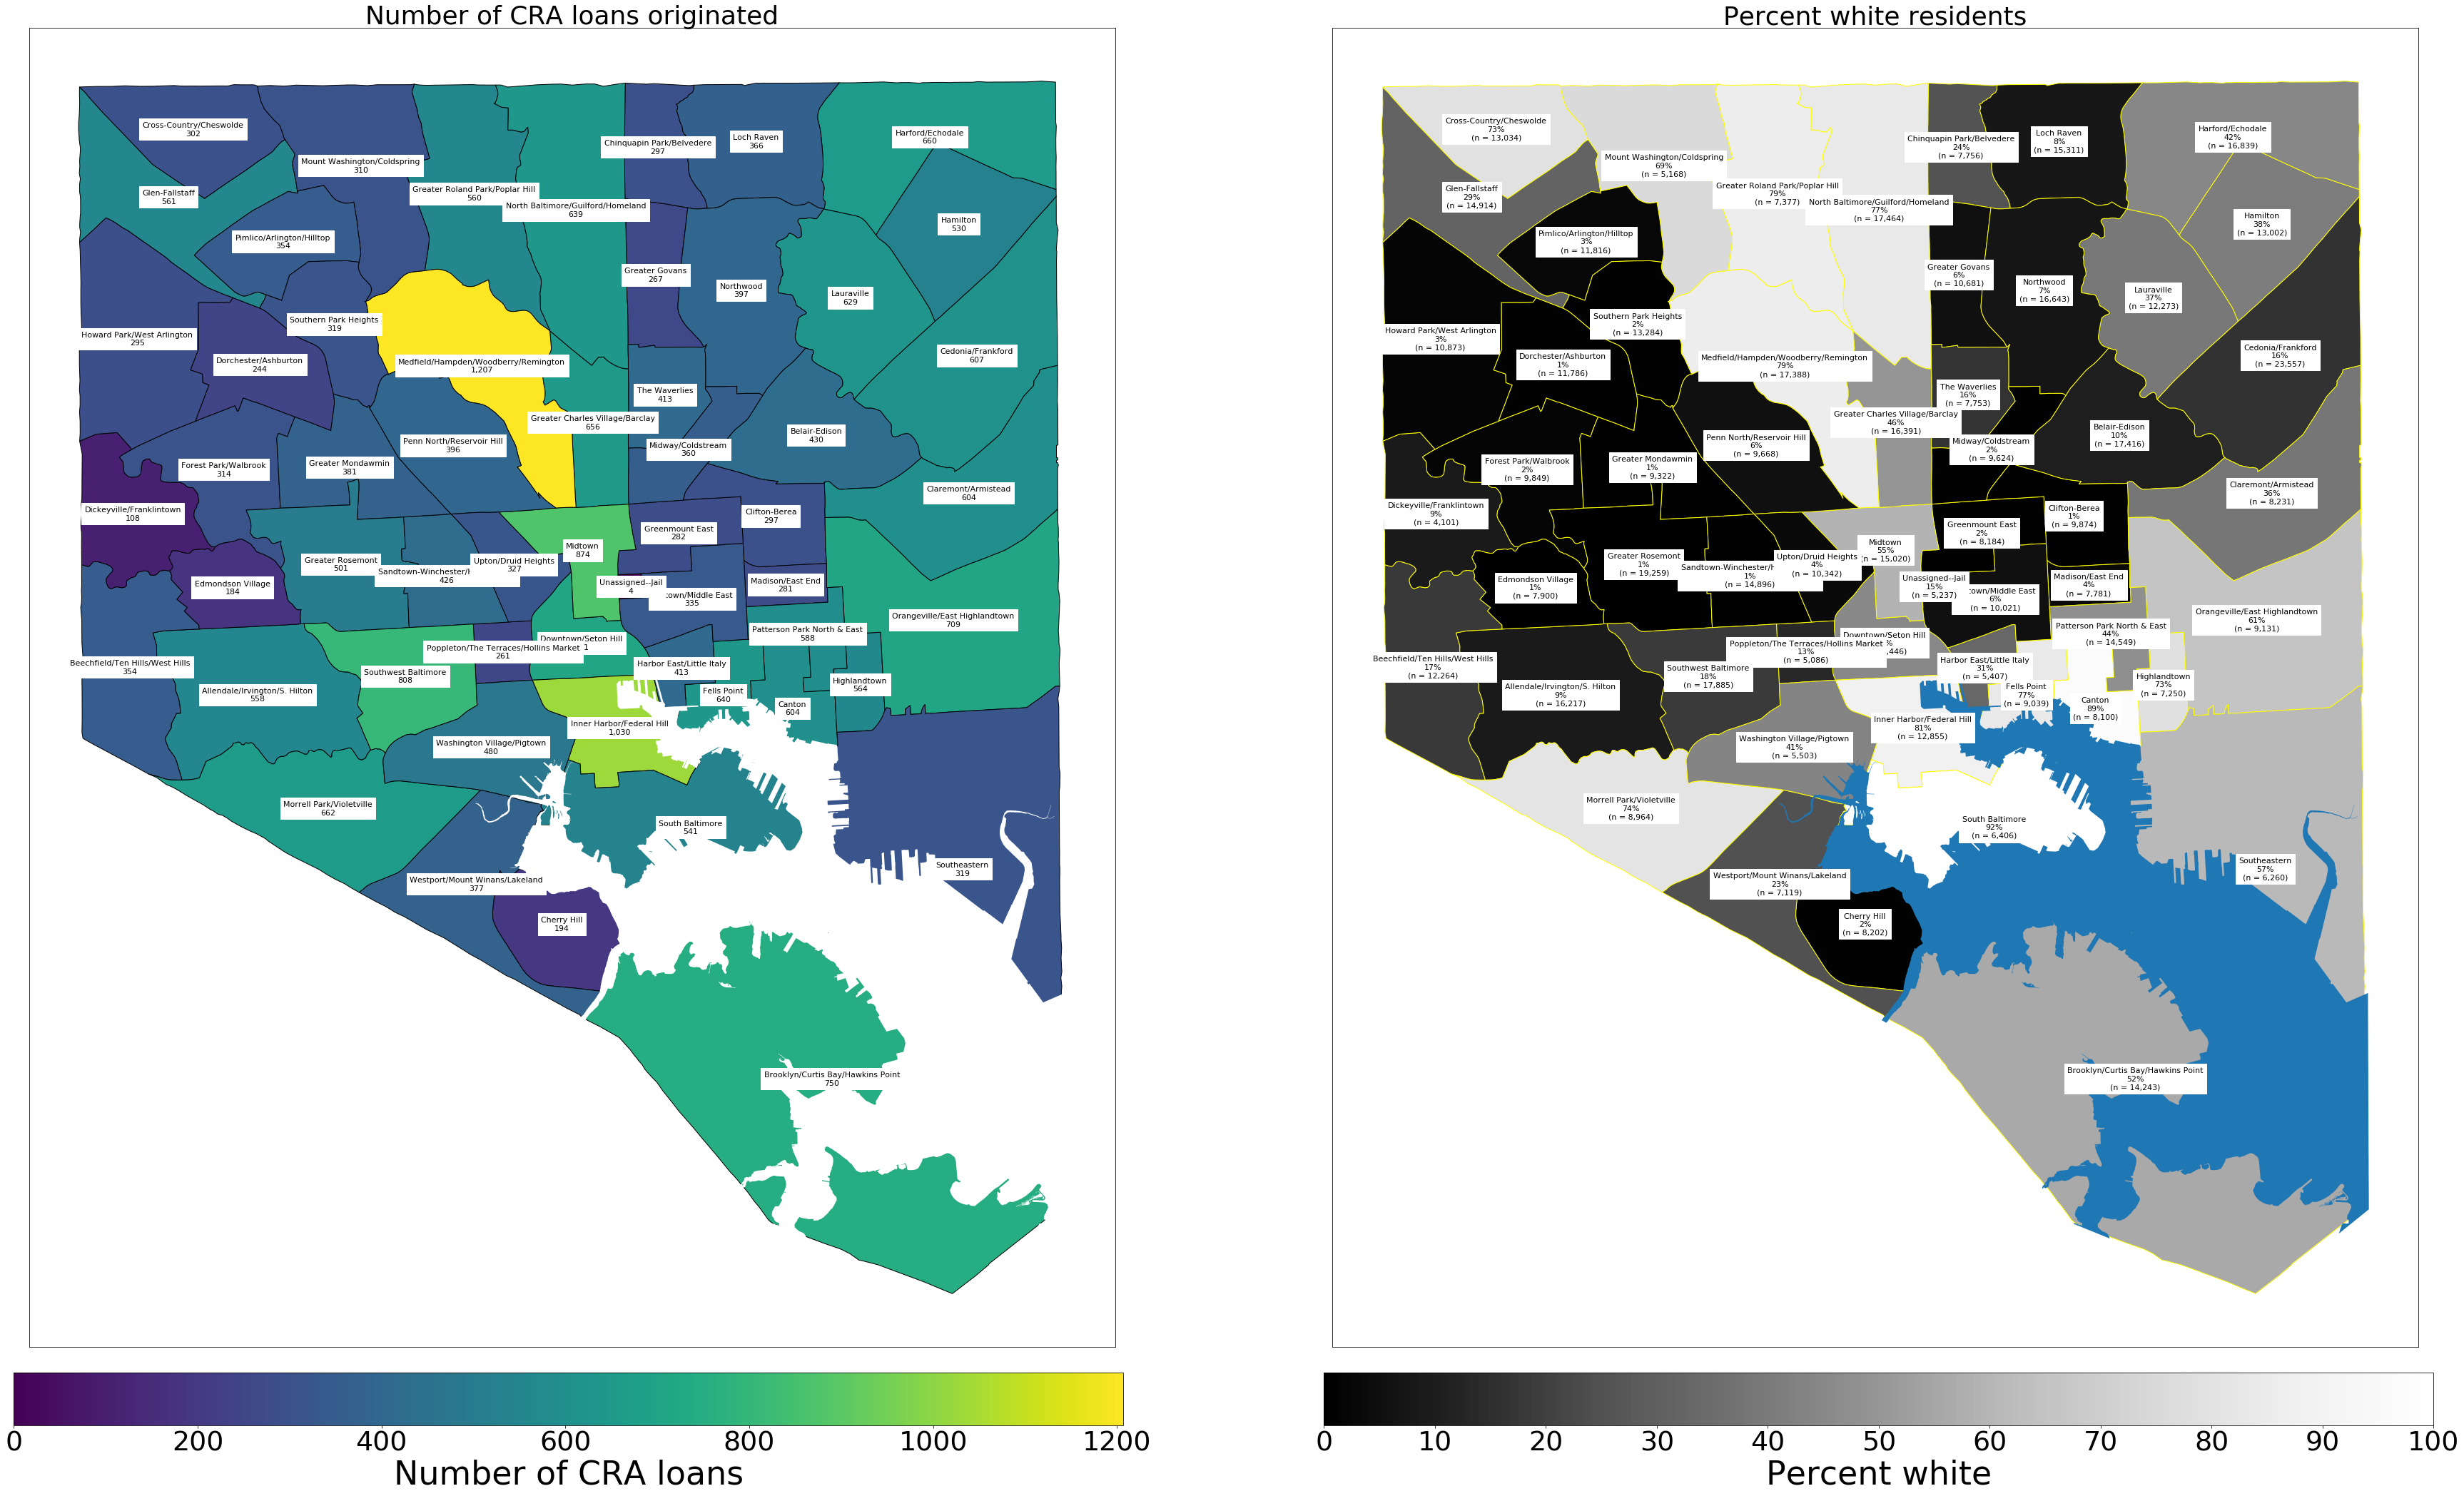

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60,34))

ax1 = csa_gdf.plot(ax=ax1, column='nLoans', cmap='viridis', edgecolor='black')
ax1.set_title('Number of CRA loans originated', fontsize=36)
ax1.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax1, color='w')

for ix, thisrow in csa_gdf[csa_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0f}'.format(thisrow['nLoans'])
#        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax1.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)




ax2 = csa_gdf.plot(ax=ax2, column='percent_white', cmap='Greys_r', edgecolor='yellow')
ax2.set_title('Percent white residents', fontsize=36)
ax2.set_aspect('equal')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax2)

for ix, thisrow in csa_gdf[csa_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0%}'.format(thisrow['percent_white'])
        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax2.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)


ax1.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')
ax2.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])
sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=csa_gdf['nLoans'].max()))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, orientation='horizontal')

cax1.tick_params(labelsize=38)
cbar1.set_label('Number of CRA loans', fontsize=46)


# add colorbar
cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
sm2 = plt.cm.ScalarMappable(cmap='Greys_r', norm=plt.Normalize(vmin=0, vmax=100))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', ticks=np.arange(0, 110, 10), orientation='horizontal')

cax2.tick_params(labelsize=38)
cbar2.set_label('Percent white', fontsize=46)

#plt.show()

print('Saving...')
fig.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_loans_by_csa.svg', format='svg', dpi=300)
print('DONE!')


## Optional: Prove that CSA names from population data match CSA names from loan data - YAY, THEY DO!

In [ ]:
#csa_from_pop_list = csapop_df.index.values.tolist()
#csa_from_loans_list = grouped_by_csa.index.values.tolist()
#
#csa_from_pop_list = [x.strip() for x in csa_from_pop_list]
#csa_from_loans_list = [x.strip() for x in csa_from_loans_list]
#
#thismany = max(len(csa_from_pop_list), len(csa_from_loans_list))
#
#htmlstring = '<table>'
#htmlstring += '<tr><th>CSA from pop</th><th>CSA from loans</th><th>Match?</th></tr>'
#
#for i in range(0, thismany):
#    htmlstring += '<tr>'
#    try:
#        htmlstring += '<td>'+csa_from_pop_list[i]+'</td>'
#    except IndexError:
#        htmlstring += '<td>-</td>'
#    try:
#        htmlstring += '<td>'+csa_from_loans_list[i]+'</td>'
#    except IndexError:
#        htmlstring += '<td>-</td>'
#    try:
#        htmlstring += '<td>'
#        if (csa_from_pop_list[i] == csa_from_loans_list[i]):
#            htmlstring += 'YES'
#        else:
#            htmlstring += 'no'
#        htmlstring += '</td>'
#    except IndexError:
#        htmlstring += '<td>-</td>'        
#    htmlstring += '</tr>'
#    
#htmlstring += '</table>'
#display(HTML(htmlstring))
print('skipping...')

In [ ]:
s = time.time()
print('reading shapefile...')
csashapes_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/csa2/community_statistical_area.shp', encoding='utf-8')
csashapes_gdf = csashapes_gdf.set_index('DC55NEIG')
e = time.time()

print('Read {0:,.0f} Baltimore city CSAs in {1:.3f} seconds.'.format(len(csashapes_gdf), e-s))

csashapes_gdf

## Connect shape data to population and loan data

In [ ]:
print('Grouping loan data by CSA only...')
grouped_by_csa = csaloans_df.groupby('CSA2010').sum()

print('We have shape data for {0:,.0f} CSAs, pop data for {1:,.0f}, and loan data for {2:,.0f}'.format(len(csashapes_gdf), len(csapop_df), len(grouped_by_csa)))
#csapop_df.sample(2) 

csa_from_shape_list = csashapes_gdf.index.values.tolist()
csa_from_pop_list = csapop_df.index.values.tolist()
csa_from_loans_list = grouped_by_csa.index.values.tolist()

csa_from_shape_list = [x.strip() for x in csa_from_shape_list]
csa_from_pop_list = [x.strip() for x in csa_from_pop_list]
csa_from_loans_list = [x.strip() for x in csa_from_loans_list]

thismany = max(len(csa_from_shape_list), len(csa_from_pop_list), len(csa_from_loans_list))

htmlstring = '<table>'
htmlstring += '<tr><th>CSA from shapes</th><th>CSA from pop</th><th>CSA from loans</th><th>Match?</th></tr>'


for i in range(0, thismany):
    htmlstring += '<tr>'
    try:
        htmlstring += '<td>'+csa_from_shape_list[i]+'</td>'
    except IndexError:
        htmlstring += '<td>-</td>'
    try:
        htmlstring += '<td>'+csa_from_pop_list[i]+'</td>'
    except IndexError:
        htmlstring += '<td>-</td>'
    try:
        htmlstring += '<td>'+csa_from_loans_list[i]+'</td>'
    except IndexError:
        htmlstring += '<td>-</td>'
    try:
        htmlstring += '<td>'
        if ((csa_from_shape_list[i] == csa_from_pop_list[i]) & (csa_from_shape_list[i] == csa_from_loans_list[i]) & (csa_from_pop_list[i] == csa_from_loans_list[i])):
            htmlstring += 'YES'
        else:
            htmlstring += 'no'
        htmlstring += '</td>'
    except IndexError:
        htmlstring += '<td>-</td>'        
    htmlstring += '</tr>'
    
htmlstring += '</table>'
display(HTML(htmlstring))


# Fix by removing from shape data:
## 'Unassigned--Crew of Vessels', 'Tract Not Assigned'
# Fix by changing CSA name in shape data:
# 'Brooklyn/Curtis Bay/Hawkins Pt' -> 'Brooklyn/Curtis Bay/Hawkins Point'
# 'Chinquapin Pk/Belvedere' -> 'Chinquapin Park/Belvedere'
# 'Edmonson Village' -> 'Edmondson Village'
# 'Forest Pk/Walbrook' -> 'Forest Park/Walbrook'
# 'Glen-Falstaff' -> 'Glen-Fallstaff'
# 'Greater Charles Vill./Barclay' -> 'Greater Charles Village/Barclay'
# 'Greater Roland Pk/Poplar' -> 'Greater Roland Park/Poplar Hill'




In [ ]:

#print('\nCalculating percent black...')
#tract_shapes_gdf = tract_shapes_gdf.assign(percent_black = tract_shapes_gdf['blk_afam'] / tract_shapes_gdf['population'])


print('getting tract loan data from backup...')
csadata = csadata_bk
#csadata

#tractdata
#print('Grouping by tract only...')
#grouped_by_census_tract = tractdata.groupby('census_tract').sum()

#print('\nAdding loan data to shape data...')
#tract_shapes_gdf = tract_shapes_gdf.assign(nLoans=grouped_by_census_tract)

#print('reading water features...')
#water_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/water/water.shp', encoding='utf-8')
#water_gdf = water_gdf.set_index('OBJECTID')
#water_gdf.sort_values('Shape_Area', ascending=False)
#water_gdf.crs

#print('matching up CRSes...')
#tract_shapes_gdf = tract_shapes_gdf.to_crs(water_gdf.crs)

#print('\nbacking up...')
#tract_shapes_gdf_bk = tract_shapes_gdf

#print('ok')
csa_shapes_gdf

In [ ]:
s = time.time()
print('reading shapefile...')

csa_shapes_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/csa/community_statistical_area.shp', encoding='utf-8')
csa_shapes_gdf = csa_shapes_gdf.set_index('DC55NEIG')                            
e = time.time()

print('Read {0:,.0f} Maryland census tracts in {1:.3f} seconds.'.format(len(tract_shapes_gdf), e-s))

#print('Calculating percent black...')
#tract_shapes_gdf = tract_shapes_gdf.assign(percent_black = tract_shapes_gdf['blk_afam'] / tract_shapes_gdf['population'])


#print('Reading loan by tract data from backup...')
#grouped_by_census_tract = grouped_by_census_tract_bk

#tract_shapes_gdf = tract_shapes_gdf.assign(nLoans=grouped_by_census_tract)

#print('backing up...')
#tract_shapes_gdf_bk = tract_shapes_gdf


csa_shapes_gdf = csa_shapes_gdf[csa_shapes_gdf['NEIG55ID'] != 91]
#print('ok')
csa_shapes_gdf = csa_shapes_gdf.join(grouped_by_csa, how='left')


csa_shapes_gdf


In [ ]:
print('reading water features...')
water_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/water/water.shp', encoding='utf-8')
water_gdf = water_gdf.set_index('OBJECTID')
water_gdf.sort_values('Shape_Area', ascending=False)
#water_gdf.crs

print('matching up CRSes...')
csa_shapes_gdf = csa_shapes_gdf.to_crs(water_gdf.crs)
print('ok')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60,34))

ax1 = tract_shapes_gdf.plot(ax=ax1, column='percent_black', cmap='Greys', edgecolor='yellow')
ax1.set_title('Percent black residents', fontsize=36)
ax1.set_aspect('equal')
water_gdf.plot(ax=ax1)

for ix, thisrow in tract_shapes_gdf[tract_shapes_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0%}'.format(thisrow['percent_black'])
        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax1.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)


ax2 = csa_shapes_gdf.plot(ax=ax2, column='nLoans', cmap='viridis', edgecolor='black')
ax2.set_title('Number of CRA loans originated', fontsize=36)
ax2.set_aspect('equal')
water_gdf.plot(ax=ax2, color='w')

#for ix, thisrow in csa_shapes_gdf[csa_shapes_gdf['population'].notnull()].iterrows():
for ix, thisrow in csa_shapes_gdf.iterrows():
    annotator = str(ix)
#    if (thisrow['population'] > 0):
    annotator += '\n' + '{0:,.0f}'.format(thisrow['nLoans'])
#        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax2.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)


ax1.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')
ax2.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])
sm1 = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=100))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, format='%.0f', ticks=np.arange(0, 110, 10), orientation='horizontal')

cax1.tick_params(labelsize=36)
cbar1.set_label('Percent black', fontsize=42)

# add colorbar
cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=csa_shapes_gdf['nLoans'].max()))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cbar2 = fig.colorbar(sm2, cax=cax2, orientation='horizontal')# ticks=np.arange(0, 110, 10), orientation='horizontal')

cax2.tick_params(labelsize=36)
cbar2.set_label('Number of CRA loans', fontsize=42)

#plt.show()

print('Saving...')
fig.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_census_tracts.svg', format='svg', dpi=300)
print('DONE!')


In [ ]:
tract_list = baltimore_tracts_df['census_tract'][baltimore_tracts_df['loan_indicator'] == 'Y'].drop_duplicates().sort_values().tolist()

tract_guide_df = pandas.DataFrame(data=tract_list, columns=['census_tract'])
tract_guide_df = tract_guide_df.set_index('census_tract')

tract_guide_df = tract_guide_df.assign(nLoans = 0, 
                                       nLoansLow = 0, 
                                       nLoansModerate = 0, 
                                       nLoansMiddle = 0, 
                                       nLoansUpper = 0, 
                                       nLoansUnknown = 0)

for tractnum, thisrow in tract_guide_df.iterrows():
    tract_guide_df['nLoans'].loc[tractnum] = len(baltimore_tracts_df[baltimore_tracts_df['census_tract'] == tractnum])
    tract_guide_df['nLoansLow'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'low')])
    tract_guide_df['nLoansModerate'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'moderate')])
    tract_guide_df['nLoansMiddle'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'middle')])
    tract_guide_df['nLoansUpper'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'upper')])
    tract_guide_df['nLoansUnknown'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'unknown')])
    
    
#for thistract in tract_list:
column_order = ['nLoans', 'nLoansLow', 'nLoansModerate', 'nLoansMiddle', 'nLoansUpper', 'nLoansUnknown']
tract_guide_df = tract_guide_df[column_order]

print('Backing up...')
tract_guide_df_bk = tract_guide_df

tract_guide_df.sample(1)


In [ ]:

#loans_by_neighborhood = pandas.Series(
#    data=baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y'].groupby(['neighborhood']).size(), 
#    name='nLoans')

#loans_by_neighborhood.to_csv('loans_by_neighborhood.csv', index=True, header=True)
#print('ok')
#loans_by_neighborhood

#baltimore_tracts_df
#loans_by_neighborhood

#print('Found {0:,.0f} tracts in Baltimore City; {1:,.0f} received loans.'.format(len(baltimore_tracts_df), len(baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y'])))
#baltimore_tracts_df[['institution_name', 'activity_year']].sample(3).T
#baltimore_tracts_df.groupby(['state', 'county']).size() # All are correctly state=24 county=510
#baltimore_tracts_df.groupby(['msa', 'cbsa_name']).size() # All are correctly msa = 12580, cbsa_name = 'Baltimore-Columbia-Towson, MD'

print('\n{0:,.0f} census tracts received loans, across {1:,.0f} neighborhoods.'.format(
    len(baltimore_tracts_df['census_tract'][
        (baltimore_tracts_df['loan_indicator'] == 'Y') &
        (baltimore_tracts_df['census_tract'].notnull())
    ].drop_duplicates()
       ),
    len(baltimore_tracts_df['neighborhood'][
        (baltimore_tracts_df['loan_indicator'] == 'Y') &
        (baltimore_tracts_df['neighborhood'].notnull())
    ].drop_duplicates()
       )
))



tract_list = baltimore_tracts_df['census_tract'][baltimore_tracts_df['loan_indicator'] == 'Y'].drop_duplicates().sort_values().tolist()
#tract_list

neighborhood_list = baltimore_tracts_df['neighborhood'][
    (baltimore_tracts_df['loan_indicator'] == 'Y') &
    (baltimore_tracts_df['neighborhood'].notnull())
].drop_duplicates().sort_values().tolist()
#neighborhood_list

print('\nDONE!')


In [ ]:

tract_guide_df = pandas.DataFrame(data=tract_list, columns=['census_tract'])
tract_guide_df = tract_guide_df.set_index('census_tract')

tract_guide_df = tract_guide_df.assign(nLoans = 0, 
                                       nLoansLow = 0, 
                                       nLoansModerate = 0, 
                                       nLoansMiddle = 0, 
                                       nLoansUpper = 0, 
                                       nLoansUnknown = 0)

for tractnum, thisrow in tract_guide_df.iterrows():
    tract_guide_df['nLoans'].loc[tractnum] = len(baltimore_tracts_df[baltimore_tracts_df['census_tract'] == tractnum])
    tract_guide_df['nLoansLow'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'low')])
    tract_guide_df['nLoansModerate'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'moderate')])
    tract_guide_df['nLoansMiddle'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'middle')])
    tract_guide_df['nLoansUpper'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'upper')])
    tract_guide_df['nLoansUnknown'].loc[tractnum] = len(baltimore_tracts_df[(baltimore_tracts_df['census_tract'] == tractnum) & (baltimore_tracts_df['cra_level'] == 'unknown')])
    
    
#for thistract in tract_list:
column_order = ['nLoans', 'nLoansLow', 'nLoansModerate', 'nLoansMiddle', 'nLoansUpper', 'nLoansUnknown']
tract_guide_df = tract_guide_df[column_order]

print('Backing up...')
tract_guide_df_bk = tract_guide_df

tract_guide_df.sample(1)


In [ ]:
s = time.time()
print('reading shapefile...')

tracts_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/census_tracts_2010/geo_export_c50bbe56-543e-4878-9c9f-c56be327600a.shp', encoding='utf-8')
tracts_gdf = tracts_gdf.assign(tractname = pandas.to_numeric(tracts_gdf['name'].apply(lambda x: x.split(' ')[-1]), errors='coerce'))
tracts_gdf = tracts_gdf.set_index('tractname')
e = time.time()

print('Read {0:,.0f} Maryland census tracts in {1:.3f} seconds.'.format(len(tracts_gdf), e-s))


print('Reading loan by tract data from backup...')
tract_guide_df = tract_guide_df_bk

tract_guide_df = tract_guide_df.join(tracts_gdf, how='left')

tract_guide_df = tract_guide_df.assign(percent_black = (tract_guide_df['blk_afam'] / tract_guide_df['population']))

tract_guide_gdf = gpd.GeoDataFrame(data=tract_guide_df, crs=tracts_gdf.crs, geometry=tracts_gdf['geometry'])

#tract_guide_gdf.sample(1)
print('backing up GeoDataFrame...')
tract_guide_gdf_bk = tract_guide_gdf
print('OK')
#tract_guide_gdf.sample(1).T


In [ ]:
print('reading from backup...')
tract_guide_gdf = tract_guide_gdf_bk

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(60,34))

ax1 = tract_guide_gdf.plot(ax=ax1, column='percent_black', cmap='Greys', edgecolor='yellow')
ax1.set_title('Percent black residents', fontsize=36)
ax1.set_aspect('equal')

for ix, thisrow in tract_guide_gdf[tract_guide_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0%}'.format(thisrow['percent_black'])
        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax1.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)


ax2 = tract_guide_gdf.plot(ax=ax2, column='nLoans', cmap='viridis', edgecolor='black')
ax2.set_title('Number of CRA loans originated', fontsize=36)
ax2.set_aspect('equal')

for ix, thisrow in tract_guide_gdf[tract_guide_gdf['population'].notnull()].iterrows():
    annotator = str(ix)
    if (thisrow['population'] > 0):
        annotator += '\n' + '{0:,.0f}'.format(thisrow['nLoans'])
#        annotator += '\n' + '(n = {0:,.0f})'.format(thisrow['population'])
    ax2.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', backgroundcolor='white', fontsize=11)


ax1.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')
ax2.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])
sm1 = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=100))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, format='%.0f', ticks=np.arange(0, 110, 10), orientation='horizontal')

cax1.tick_params(labelsize=36)
cbar1.set_label('Percent black', fontsize=42)

# add colorbar
cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=tract_guide_gdf['nLoans'].max()))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cbar2 = fig.colorbar(sm2, cax=cax2, format='%.0f', orientation='horizontal')# ticks=np.arange(0, 110, 10), orientation='horizontal')

cax2.tick_params(labelsize=36)
cbar2.set_label('Number of CRA loans', fontsize=42)

#plt.show()

print('Saving...')
fig.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_census_tracts.svg', format='svg', dpi=300)
print('DONE!')


In [ ]:
neighborhood_guide_df = pandas.DataFrame(data=neighborhood_list, columns=['neighborhood'])
neighborhood_guide_df = neighborhood_guide_df.set_index('neighborhood')

neighborhood_guide_df = neighborhood_guide_df.assign(nLoans = 0, 
                                       nLoansLow = 0, 
                                       nLoansModerate = 0, 
                                       nLoansMiddle = 0, 
                                       nLoansUpper = 0, 
                                       nLoansUnknown = 0)

for nh, thisrow in neighborhood_guide_df.iterrows():
    neighborhood_guide_df['nLoans'].loc[nh] = len(baltimore_tracts_df[baltimore_tracts_df['neighborhood'] == nh])
    neighborhood_guide_df['nLoansLow'].loc[nh] = len(baltimore_tracts_df[(baltimore_tracts_df['neighborhood'] == nh) & (baltimore_tracts_df['cra_level'] == 'low')])
    neighborhood_guide_df['nLoansModerate'].loc[nh] = len(baltimore_tracts_df[(baltimore_tracts_df['neighborhood'] == nh) & (baltimore_tracts_df['cra_level'] == 'moderate')])
    neighborhood_guide_df['nLoansMiddle'].loc[nh] = len(baltimore_tracts_df[(baltimore_tracts_df['neighborhood'] == nh) & (baltimore_tracts_df['cra_level'] == 'middle')])
    neighborhood_guide_df['nLoansUpper'].loc[nh] = len(baltimore_tracts_df[(baltimore_tracts_df['neighborhood'] == nh) & (baltimore_tracts_df['cra_level'] == 'upper')])
    neighborhood_guide_df['nLoansUnknown'].loc[nh] = len(baltimore_tracts_df[(baltimore_tracts_df['neighborhood'] == nh) & (baltimore_tracts_df['cra_level'] == 'unknown')])
    

column_order = ['nLoans', 'nLoansLow', 'nLoansModerate', 'nLoansMiddle', 'nLoansUpper', 'nLoansUnknown']
neighborhood_guide_df = neighborhood_guide_df[column_order]
neighborhood_guide_df#[neighborhood_guide_df['nLoans'] == neighborhood_guide_df['nLoansLow']]


In [ ]:
nfile = '/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/Neighborhoods.shp'
ngeo = gpd.read_file(nfile)
print('Geographies read')
#ngeo = ngeo.set_index('Name')
ngeo = ngeo.assign(percent_white=100*(ngeo['White']/ngeo['Population']))
ngeo = ngeo.assign(percent_black=100*(ngeo['Blk_AfAm']/ngeo['Population']))

ngeo.assign(big_neighborhood='')

ngeo.loc[ngeo['Name'].isin(['Canton', 'Cherry Hill', 'Edmondson Village', 'Highlandtown', 'Lauraville', 'Loch Raven', 'South Baltimore']), 'big_neighborhood'] = ngeo['Name']

ngeo.loc[ngeo['Name'].isin(['Allendale', 'Irvington', 'Carroll-South Hilton']), 'big_neighborhood'] = 'Allendale/Irvington/S. Hilton'
ngeo.loc[ngeo['Name'].isin(['Beechfield', 'Ten Hills', 'West Hills']), 'big_neighborhood'] = 'Beechfield/Ten Hills/West Hills'
ngeo.loc[ngeo['Name'].isin(['Brooklyn', 'Curtis Bay', 'Hawkins Point']), 'big_neighborhood'] = 'Brooklyn/Curtis Bay/Hawkins Point'
ngeo.loc[ngeo['Name'].isin(['Cedonia', 'Frankford']), 'big_neighborhood'] = 'Cedonia/Frankford'
ngeo.loc[ngeo['Name'].isin(['Chinquapin Park', 'Belvedere']), 'big_neighborhood'] = 'Chinquapin Park/Belvedere'
ngeo.loc[ngeo['Name'].isin(['Berea', 'Clifton Park', 'South Clifton Park']), 'big_neighborhood'] = 'Clifton-Berea'
ngeo.loc[ngeo['Name'].isin(['Cross Country', 'Cheswolde']), 'big_neighborhood'] = 'Cross-Country/Cheswolde'
ngeo.loc[ngeo['Name'].isin(['Dickeyville', 'Franklintown']), 'big_neighborhood'] = 'Dickeyville/Franklintown'
ngeo.loc[ngeo['Name'].isin(['Dorchester', 'Ashburton']), 'big_neighborhood'] = 'Dorchester/Ashburton'
ngeo.loc[ngeo['Name'].isin(['Downtown', 'Downtown West' 'Seton Hill']), 'big_neighborhood'] = 'Downtown/Seton Hill'
ngeo.loc[ngeo['Name'].isin(['Fells Point', 'Upper Fells Point']), 'big_neighborhood'] = 'Fells Point'
ngeo.loc[ngeo['Name'].isin(['Central Forest Park', 'Concerned Citizens Of Forest Park', 'Forest Park', 'Forest Park Golf Course', 'West Forest Park', 'Walbrook']), 'big_neighborhood'] = 'Forest Park/Walbrook'
ngeo.loc[ngeo['Name'].isin(['Glen', 'Fallstaff']), 'big_neighborhood'] = 'Glen-Fallstaff'
ngeo.loc[ngeo['Name'].isin(['Charles Village', 'Barclay']), 'big_neighborhood'] = 'Greater Charles Village/Barclay'
ngeo.loc[ngeo['Name'].isin(['Mid-Govans', 'Winston-Govans']), 'big_neighborhood'] = 'Greater Govans'
ngeo.loc[ngeo['Name'].isin(['Mondawmin']), 'big_neighborhood'] = 'Greater Mondawmin'
ngeo.loc[ngeo['Name'].isin(['Roland Park', 'North Roland Park/Poplar Hill']), 'big_neighborhood'] = 'Greater Roland Park/Poplar Hill'
ngeo.loc[ngeo['Name'].isin(['Rosemont', 'Rosemont East', 'Rosemont Homeowners/Tenants']), 'big_neighborhood'] = 'Greater Rosemont'
ngeo.loc[ngeo['Name'].isin(['Hamilton Hills']), 'big_neighborhood'] = 'Hamilton'
ngeo.loc[ngeo['Name'].isin(['Little Italy']), 'big_neighborhood'] = 'Harbor East/Little Italy'
ngeo.loc[ngeo['Name'].isin(['North Harford Road']), 'big_neighborhood'] = 'Harford/Echodale'
ngeo.loc[ngeo['Name'].isin(['Howard Park', 'West Arlington']), 'big_neighborhood'] = 'Howard Park/West Arlington'
ngeo.loc[ngeo['Name'].isin(['Inner Harbor', 'Federal Hill']), 'big_neighborhood'] = 'Inner Harbor/Federal Hill'
ngeo.loc[ngeo['Name'].isin(['Madison-Eastend']), 'big_neighborhood'] = 'Madison/East End'
ngeo.loc[ngeo['Name'].isin(['Medfield', 'Hampden', 'Woodberry', 'Remington']), 'big_neighborhood'] = 'Medfield/Hampden/Woodberry/Remington'
ngeo.loc[ngeo['Name'].isin(['Mid-Town Belvedere', 'Midtown-Edmondson']), 'big_neighborhood'] = 'Midtown'
ngeo.loc[ngeo['Name'].isin(['East Baltimore Midway', 'Coldstream Homestead Montebello']), 'big_neighborhood'] = 'Midway/Coldstream'
ngeo.loc[ngeo['Name'].isin(['Morrell Park', 'Violetville']), 'big_neighborhood'] = 'Morrell Park/Violetville'
ngeo.loc[ngeo['Name'].isin(['Mount Washington', 'Coldspring']), 'big_neighborhood'] = 'Mount Washington/Coldspring'
ngeo.loc[ngeo['Name'].isin(['Guilford', 'Homeland', 'Villages Of Homeland', 'York-Homeland']), 'big_neighborhood'] = 'North Baltimore/Guilford/Homeland'
ngeo.loc[ngeo['Name'].isin(['New Northwood', 'Original Northwood']), 'big_neighborhood'] = 'Northwood'
ngeo.loc[ngeo['Name'].isin(['Oldtown', 'Middle East']), 'big_neighborhood'] = 'Oldtown/Middle East'
ngeo.loc[ngeo['Name'].isin(['Orangeville']), 'big_neighborhood'] = 'Orangeville/East Highlandtown'
ngeo.loc[ngeo['Name'].isin(['Patterson Park Neighborhood', 'Patterson Park']), 'big_neighborhood'] = 'Patterson Park North & East'
ngeo.loc[ngeo['Name'].isin(['Penn North', 'Reservoir Hill']), 'big_neighborhood'] = 'Penn North/Reservoir Hill'
ngeo.loc[ngeo['Name'].isin(['Pimlico Good Neighbors', 'Arlington', 'East Arlington', 'West Arlington']), 'big_neighborhood'] = 'Pimlico/Arlington/Hilltop'
ngeo.loc[ngeo['Name'].isin(['Pimlico Good Neighbors', 'Arlington', 'East Arlington', 'West Arlington']), 'big_neighborhood'] = 'Pimlico/Arlington/Hilltop'
ngeo.loc[ngeo['Name'].isin(['Poppleton', 'Hollins Market']), 'big_neighborhood'] = 'Poppleton/The Terraces/Hollins Market'
ngeo.loc[ngeo['Name'].isin(['Poppleton', 'Hollins Market']), 'big_neighborhood'] = 'Poppleton/The Terraces/Hollins Market'
ngeo.loc[ngeo['Name'].isin(['Sandtown-Winchester', 'Harlem Park']), 'big_neighborhood'] = 'Sandtown-Winchester/Harlem Park'
ngeo.loc[ngeo['Name'].isin(['Better Waverly', 'Waverly']), 'big_neighborhood'] = 'The Waverlies'
ngeo.loc[ngeo['Name'].isin(['Upton', 'Druid Heights']), 'big_neighborhood'] = 'Upton/Druid Heights'
ngeo.loc[ngeo['Name'].isin(['Westport', 'Mount Winans', 'Lakeland']), 'big_neighborhood'] = 'Westport/Mt. Winans/Lakeland'

ngeo = ngeo.fillna('')

#ngeo['big_neighborhood'].drop_duplicates().sort_values()
#ngeo['Name'][ngeo['Name'].apply(lambda x: 'lake' in x.lower())]

#neighborhood_guide_df.head(2)
ngeo.sample(1)
#ngeo['geodataEGI']
#len(ngeo)

In [ ]:
# Find neighborhoods that still need to be matched to bigger neighborhoods
#ngeo['Name'][ngeo['big_neighborhood'] == ''].sort_values().to_csv('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/mystery_neighborhoods.csv', encoding='utf-8')
#print('ok')
neighborhood_guide_df_bk = neighborhood_guide_df
print('backed up')

In [ ]:
#neighborhood_guide_df.reset_index().merge(ngeo, )
#ngeo.columns
#guide_neighborhoods_list = neighborhood_guide_df.index.values.tolist()
neighborhood_guide_df = neighborhood_guide_df_bk
print('retrieved from backup')

s = time.time()
columns_to_agg = ngeo.columns.tolist()
do_not_agg_list = ['Name', 'OBJECTID', 'COLOR_2', 'geodataEGI', 'Pop_dens', 'AveHHsize']
do_not_agg_list += ['created_us', 'created_da', 'last_edite', 'last_edi_1']
do_not_agg_list += ['ShapeSTAre', 'ShapeSTLen', 'geometry']
do_not_agg_list += ['percent_white', 'percent_black', 'big_neighborhood']
for x in do_not_agg_list:
    columns_to_agg.remove(x)

new_columns_df = pandas.DataFrame(data=None, columns=columns_to_agg, index=neighborhood_guide_df.index)
neighborhood_guide_df = pandas.concat([neighborhood_guide_df, new_columns_df], axis=1)

for thisnh, thisrow in neighborhood_guide_df.iterrows():
    print(thisnh+'...')
    for thiscol in columns_to_agg:
        #print(neighborhood_guide_df[thiscol].loc[thisnh])
#        z = 
        #print('{0}: {1:,.0f}'.format(thiscol, z))
        neighborhood_guide_df.loc[thisnh, thiscol] = ngeo[thiscol][ngeo['big_neighborhood'] == thisnh].sum()
        #print(ngeo.groupby('big_neighborhood')[thiscol].sum().values[0])
    #print('\n')
#        neighborhood_guide_df.loc[thisnh, thiscol] = ngeo.groupby('big_neighborhood')[thiscol].sum()#ngeo[ngeo['big_neighborhood'] == thisnh][thiscol].sum()
#        print('\n')
#    
    #print('\n')

print('Got all {0:,.0f} big neighborhoods!'.format(len(neighborhood_guide_df)))

print('adding percent black...')
neighborhood_guide_df = neighborhood_guide_df.assign(percent_black=100*(neighborhood_guide_df['Blk_AfAm'][neighborhood_guide_df['Population'] > 0] / neighborhood_guide_df['Population'][neighborhood_guide_df['Population'] > 0]))
e = time.time()

print('backing up...')
neighborhood_guide_df_bk = neighborhood_guide_df

print('\nDONE in {0:0f} seconds.'.format(e-s))


In [ ]:
print('retrieving from backup...')
neighborhood_guide_df = neighborhood_guide_df_bk

thecrs = {'init':'EPSG:6487'}
ngdf = gpd.GeoDataFrame(data=ngeo, crs=thecrs)
ngdf = ngdf.set_geometry('geometry')

gdf = gpd.GeoDataFrame(neighborhood_guide_df, crs=thecrs)
gdf = gdf.assign(geometry=Polygon())
gdf = gdf.set_geometry('geometry')


print('\nAssigning geometry...')
#neighborhood_guide_df = neighborhood_guide_df.assign(geometry=Polygon())

for thisnh, thisrow in gdf.iterrows():
#    #print(thisnh)
    compns = ngeo['Name'][ngeo['big_neighborhood'] == thisnh].tolist()
    thesegeos = []
    for i in range(0, len(compns)):
        thesegeos.append(ngdf.geometry[ngeo['Name'] == compns[i]].values[0])
    #print(thesegeos)
    onegeo = cascaded_union(thesegeos)
    if (len(compns) > 0):
        #gdf.loc[thisnh, 'geometry'] = onegeo
        gdf.geometry.loc[thisnh] = onegeo

print('backing up...')
gdf_bk = gdf
print('DONE!')

In [ ]:
gdf['nLoans'].sort_values()

In [ ]:
#### DISPLAY FOR ONE STATE AT A TIME

#### DISPLAY BLACK AND WHITE ON TWO SEPARATE MAPS; ALSO SET COORD LIMITS MANUALLY
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,8))

ax1 = gdf.plot(ax=ax1, column='percent_black', cmap='Greys', edgecolor='yellow')
ax1.set_title('Percent black (from OpenBaltimore GIS)', fontsize=12)
ax1.set_aspect('equal')

ax2 = gdf.plot(ax=ax2, column='nLoans', cmap='viridis', edgecolor='black')
ax2.set_title('Number of CRA loans originated', fontsize=12)
ax2.set_aspect('equal')

ax1.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')
ax2.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

# add colorbar
cax1 = fig.add_axes([0.12, 0.08, 0.36, 0.03])
sm1 = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0, vmax=100))

# fake up the array of the scalar mappable. Urgh...
sm1._A = []

cbar1 = fig.colorbar(sm1, cax=cax1, format='%.0f', ticks=np.arange(0, 110, 10), orientation='horizontal')

cax1.tick_params(labelsize=12)
cbar1.set_label('Percent black', fontsize=16)

# add colorbar
cax2 = fig.add_axes([0.545, 0.08, 0.36, 0.03])
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=2300))

# fake up the array of the scalar mappable. Urgh...
sm2._A = []

cbar2 = fig.colorbar(sm2, cax=cax2, format='.0f', orientation='horizontal')# ticks=np.arange(0, 110, 10), orientation='horizontal')

cax2.tick_params(labelsize=12)
cbar2.set_label('Number of CRA loans', fontsize=16)

#plt.title('Alabama 2016 Presidential election results by congressional district', fontsize=20, position=(-0.05,27.5))
plt.show()
#print('ok')

#gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
#type(ourdata_gdf)
print('Saving...')
fig.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_csa.svg', format='svg', dpi=300)
print('DONE!')

In [ ]:
nfile = '/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/Neighborhoods.shp'
ngeo = gpd.read_file(nfile)
ngeo = ngeo.set_index('OBJECTID')
ngeo.sample(1)
neighborhoods_list = ngeo.groupby('Name').size().sort_index().index.values.tolist()
with io.open('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/neighborhoods_list.csv', 'w') as f:
    f.write('neighborhood')
    f.write('\n')
    for thisn in neighborhoods_list:
        towrite = thisn + '\n'
        f.write(towrite)
print('DONE!')